# EcoFOCI CTD

Choose upper 5m of data.  Will need to be careful about multiple ctd's in a day (no daily averages) and how to compare them to sat data (does an offset need to be had?)

## Gather CTD data (locations) first

Use internal erddap to get list of all relevant CTD's in Bering/Arctic  
Use erddap to get collocated SST data (from a variety of sources... MUR, MUR4.2, NOAAOISST - others?)
+ hand build url instead of erddapy (since erddapy is a url builder with a few wrapped convenience functions)
+ daily sat retrievals (but CTD could be higher resolution so do some analysis)

In [6]:
from erddapy import ERDDAP
import pandas as pd

import numpy as np 
import urllib.request 
import xarray as xr 
import time 
from matplotlib import pyplot as plt 
from datetime import date,datetime

np.warnings.filterwarnings('ignore')

In [129]:
ecofoci_server_url='http://ecofoci-field.pmel.noaa.gov:8080/erddap'

sat_server_url="https://coastwatch.pfeg.noaa.gov/erddap/"

sat_server_url = sat_server_url+'griddap/jplMURSST41_Lon0360.csvp?analysed_sst' #MUR path
sat_server_url

'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41_Lon0360.csvp?analysed_sst'

ingest all available Bering Sea / Arctic CTD's in internal repository

pull just lat/lon and upper 5m temperatures (from both sensors)

In [235]:
e = ERDDAP(server=ecofoci_server_url,
           protocol="tabledap",)
df = pd.read_csv(e.get_search_url(response='csv', search_for='CTD Final')) #expand later
print(f"{df['Dataset ID'].count()} datasets to be looped through")
print("Names:", df['Dataset ID'].values)

154 datasets to be looped through
Names: ['CTD_ae1001_final' 'CTD_ae1401_final' 'CTD_ae1402_final'
 'CTD_ae1501_final' 'CTD_aq1201_final' 'CTD_aq1301_final'
 'CTD_aq1401l2_final' 'CTD_aq1401l3_final' 'CTD_aq1501_final'
 'CTD_aq1601_final' 'CTD_aq1601_final_merged' 'CTD_aq1801_final'
 'CTD_be1201_final' 'CTD_be1301_final' 'CTD_be1302_final'
 'CTD_be1303_final' 'CTD_cf1601_final' 'CTD_dy1006_final'
 'CTD_dy1104_final' 'CTD_dy1207_final' 'CTD_dy1208_final'
 'CTD_dy1408l1_final' 'CTD_dy1408l2_final' 'CTD_dy1408l3_final'
 'CTD_dy1508_final' 'CTD_dy1509_final' 'CTD_dy1608l1_final'
 'CTD_dy1608l2_final' 'CTD_dy1608l3_final' 'CTD_dy1609l1_final'
 'CTD_dy1609l1_final_merged' 'CTD_dy1609l2_final'
 'CTD_dy1609l2_final_merged' 'CTD_dy1610_final' 'CTD_dy1610_final_merged'
 'CTD_dy1704_final' 'CTD_dy1708_final' 'CTD_dy1807l1_final'
 'CTD_dy1807l2_final' 'CTD_dy1807l3_final' 'CTD_dy1904_final'
 'CTD_dy1905_final' 'CTD_dy1905_final_merged' 'CTD_dy1906l1_final'
 'CTD_dy1906l2_final' 'CTD_dy1906l3_final

In [205]:
dfs = {}
for dataset in df['Dataset ID'].values:
    if dataset.endswith('final'):
        e.dataset_id = dataset
        e.variables = [
            "pressure",
            "latitude",
            "longitude",
            "T_28",
            "T2_35",
            "time",
            "profile_id"
        ]
        e.constraints = {
            "pressure<=": 5.0,}
        dftemp = e.to_pandas()
        dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]
        dfs.update({dataset:dftemp})

In [206]:
#get shallowest value for each ctd
tdf = pd.DataFrame()
for dfname, df_data in dfs.items():
    for g in df_data.groupby('profile_id').groups.keys():
        try:
            tdf = tdf.append(df_data.groupby('profile_id').get_group(g)[df_data.groupby('profile_id').get_group(g).pressure == df_data.groupby('profile_id').get_group(g).pressure.min()]
                         ,ignore_index=True)
        except:
            print('{dataset} failed to be grouped')

In [210]:
tdf

,pressure,latitude,longitude,T_28,T2_35,time,profile_id
0,0.0,65.633000,191.54800,9.5301,NaN,2010-09-05T11:22:00Z,ae1001c011_ctd
1,0.0,65.722000,191.19080,8.2601,NaN,2010-09-05T13:36:00Z,ae1001c012_ctd
2,0.0,69.598660,191.40530,8.3888,NaN,2010-09-06T14:08:00Z,ae1001c013_ctd
3,0.0,69.398500,192.00070,8.9510,NaN,2010-09-06T16:46:00Z,ae1001c014_ctd
4,0.0,69.291340,192.42820,9.0467,NaN,2010-09-06T18:06:00Z,ae1001c015_ctd
...,...,...,...,...,...,...,...
5898,2.0,62.466167,185.91667,9.4325,9.4341,2017-09-13T03:52:00Z,hly1702c137
5899,2.0,62.387500,185.42566,9.4500,9.4496,2017-09-13T05:14:00Z,hly1702c138
5900,1.0,62.218166,185.11750,9.3926,9.3919,2017-09-13T08:12:00Z,hly1702c139
5901,3.0,62.044334,184.78984,9.6184,9.6173,2017-09-13T09:39:00Z,hly1702c140


<AxesSubplot:>

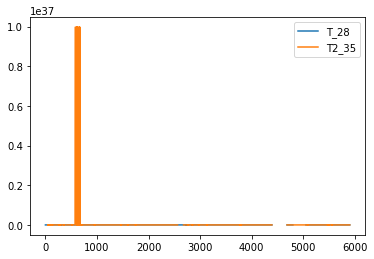

In [211]:
tdf[['T_28','T2_35']].plot()

In [212]:
dates = [(x.date()).strftime('%Y-%m-%d') for x in pd.to_datetime(tdf['time'])]
lon = tdf['longitude'].values
lat = tdf['latitude'].values

In [213]:
#get MUR data at same lat/lons on same day (but wont be time equal)

start_time=time.time() 

col_names = ["date","matched_lat","matched_lon","matched_temp"]
tot=pd.DataFrame(columns = col_names)

for i in range(len(dates)):
#for i in range(2):
    if (i % 100) == 0:
        print(i,len(dates))
    #this is where the URL is built:
    try:
        url=sat_server_url+"[("+str(dates[i])+"T09:00:00Z):1:("+str(dates[i])+"T09:00:00Z)][("+str(lat[i])+"):1:("+str(lat[i])+")][("+str(lon[i])+"):1:("+str(lon[i])+")]"
        new=pd.read_csv(url,skiprows=0)
        new.columns=col_names
        tot=tot.append(new,ignore_index=True)
    except:
        pass

end_time=time.time()

0 5903
100 5903
200 5903
300 5903
400 5903
500 5903
600 5903
700 5903
800 5903
900 5903
1000 5903
1100 5903
1200 5903
1300 5903
1400 5903
1500 5903
1600 5903
1700 5903
1800 5903
1900 5903
2000 5903
2100 5903
2200 5903
2300 5903
2400 5903
2500 5903
2600 5903
2700 5903
2800 5903
2900 5903
3000 5903
3100 5903
3200 5903
3300 5903
3400 5903
3500 5903
3600 5903
3700 5903
3800 5903
3900 5903
4000 5903
4100 5903
4200 5903
4300 5903
4400 5903
4500 5903
4600 5903
4700 5903
4800 5903
4900 5903
5000 5903
5100 5903
5200 5903
5300 5903
5400 5903
5500 5903
5600 5903
5700 5903
5800 5903
5900 5903


In [214]:
print("total time = %g mins" % ((end_time-start_time)/60.))

total time = 967.667 mins


In [215]:
ctdpmur_df = pd.concat([tot,tdf],axis=1)

In [233]:
ctdpmur_df['T2_35'][ctdpmur_df['T2_35']>1e34] = np.nan
ctdpmur_df['T_28'][ctdpmur_df['T_28']>1e34] = np.nan
ctdpmur_df['matched_temp'][ctdpmur_df['matched_temp']>1e34] = np.nan

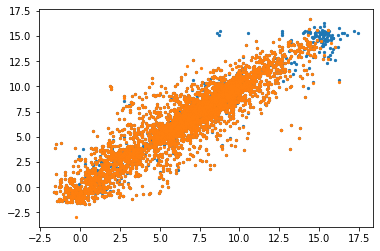

In [234]:
plt.scatter(x=ctdpmur_df['matched_temp'],y=ctdpmur_df['T_28'],s=5)
plt.scatter(x=ctdpmur_df['matched_temp'],y=ctdpmur_df['T2_35'],s=5)

**FACET PLOTS ABOVE ON:** Season, WaterMass, Time of day (morning or evening), cruise/year

In [217]:
ctdpmur_df.to_csv('focictdpmur.csv')